In [1]:
import tensorflow as tf
import warnings

if not tf.test.gpu_device_name():
    warnings.warn ("mama")
else:
    print(tf.test.gpu_device_name())

print(tf.version.VERSION)


/device:GPU:0
2.1.0


In [2]:
#import sys
#!{sys.executable} -m pip install sk
import os
import torch.nn.functional as F
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [4]:
X=np.load('D:/aminur/data/train_120.npy')
y=np.load('D:/aminur/data/test_120.npy')
print(X.shape,type(X))
#X=X.reshape(200,128,128,128)
#print('x',X[1])
print(y.shape,type(y))
#print ('y',y[1])

(120, 128, 128, 128, 1) <class 'numpy.ndarray'>
(120, 128, 128, 128, 1) <class 'numpy.ndarray'>


In [7]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, X_valid.shape,y_train.shape,y_valid.shape)

(84, 128, 128, 128, 1) (36, 128, 128, 128, 1) (84, 128, 128, 128, 1) (36, 128, 128, 128, 1)


In [8]:
from keras import backend as K 
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return -dice_coefficient(y_true, y_pred)


def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    """
    Weighted dice coefficient. Default axis assumes a "channels first" data structure
    :param smooth:
    :param y_true:
    :param y_pred:
    :param axis:
    :return:
    """
    return K.mean(2. * (K.sum(y_true * y_pred,
                              axis=axis) + smooth/2)/(K.sum(y_true,
                                                            axis=axis) + K.sum(y_pred,
                                                                               axis=axis) + smooth))


def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)


In [82]:
from keras.layers.pooling import MaxPooling3D, GlobalMaxPool3D
from keras.layers.convolutional import Conv2D, Conv3DTranspose, Conv3D
import keras
from keras.layers import SpatialDropout3D
from keras.layers import LeakyReLU
#from keras.layers.advanced_activations import PReLU
#from keras.layers import PReLU
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size,kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    #x = LeakyReLU(alpha=0.2)(x)
    #x = Activation("relu")(x)
    #x=keras.layers.advanced_activations.PReLU()(x)
    # second layer
    x = Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size,kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    #x =LeakyReLU(alpha=0.2)(x)
    #x = Activation("relu")(x)
    #x=keras.layers.advanced_activations.PReLU()(x)
    return x

In [83]:
def get_unet(input_img, n_filters=16, dropout=0.25, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling3D((2, 2,2)) (c1)
    p1 = SpatialDropout3D(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling3D((2, 2,2)) (c2)
    p2 = SpatialDropout3D(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling3D((2, 2,2)) (c3)
    p3 = SpatialDropout3D(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling3D(pool_size=(2, 2,2)) (c4)
    p4 = SpatialDropout3D(dropout)(p4)
    
    #autoencoder.add(Flatten())
    #autoencoder.add(Reshape((1,12, 12,32 )))
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv3DTranspose(n_filters*8, (3, 3,3), strides=(2,2,2),padding='same')(c5)
    #u6= Activation("relu")(u6)
    u6 = concatenate([u6, c4])
    u6 = SpatialDropout3D(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm) 
    

    u7 = Conv3DTranspose(n_filters*4, (3, 3,3), strides=(2, 2,2), padding='same')(c6)
    #u7= Activation("relu")(u7)
    u7 = concatenate([u7, c3])
    u7 = SpatialDropout3D(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv3DTranspose(n_filters*2, (3, 3,3), strides=(2, 2,2),padding='same')(c7) 
    #u8= Activation("relu")(u8)
    u8 = concatenate([u8, c2])
    u8 = SpatialDropout3D(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv3DTranspose(n_filters*1, (3, 3,3), strides=(2, 2,2),padding='same',name='man1')(c8)
    #u9= Activation("relu")(u9)
    u9 = concatenate([u9, c1],axis=4)
    u9 = SpatialDropout3D(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv3D(1, (1, 1,1), activation='tanh')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [84]:

from keras import backend 
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(backend.square(y_pred - y_true), axis=-1))

input_img = Input((128, 128, 128,1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.25, batchnorm=True)
opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
#model.compile(optimizer=opt, loss=weighted_dice_coefficient_loss, metrics=['mse', 'mae', 'mape', 'cosine',rmse,weighted_dice_coefficient, dice_coefficient])
model.compile(optimizer=opt, loss="mse", metrics=['mse', 'mae', 'mape', 'cosine',weighted_dice_coefficient, dice_coefficient,rmse])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_39 (Conv3D)              (None, 128, 128, 128 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 128 64          conv3d_39[0][0]                  
__________________________________________________________________________________________________
conv3d_40 (Conv3D)              (None, 128, 128, 128 6928        batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [85]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt_2.h5', monitor='val_loss',mode='auto',verbose=1, save_best_only=True, save_weights_only=True)
]

In [86]:
results = model.fit(X_train, y_train, batch_size=2, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid),verbose=1)

Train on 84 samples, validate on 36 samples
Epoch 1/100
84/84 [==============================] - 55s 657ms/step - loss: 0.2057 - mse: 0.2057 - mae: 0.3592 - mape: 14026.9746 - cosine: 0.0283 - weighted_dice_coefficient: -0.1817 - dice_coefficient: -0.0319 - rmse: 0.3592 - val_loss: 0.6550 - val_mse: 0.6550 - val_mae: 0.7473 - val_mape: 33939.4414 - val_cosine: -0.0837 - val_weighted_dice_coefficient: -0.1288 - val_dice_coefficient: -0.1004 - val_rmse: 0.7473

Epoch 00001: val_loss improved from inf to 0.65503, saving model to model-tgs-salt_2.h5
Epoch 2/100
84/84 [==============================] - 52s 618ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1581 - mape: 5888.5625 - cosine: 0.0954 - weighted_dice_coefficient: -0.0466 - dice_coefficient: -0.0417 - rmse: 0.1581 - val_loss: 0.1720 - val_mse: 0.1720 - val_mae: 0.3404 - val_mape: 16432.9688 - val_cosine: -0.0226 - val_weighted_dice_coefficient: -0.0836 - val_dice_coefficient: -0.1454 - val_rmse: 0.3404

Epoch 00002: val_loss improve

84/84 [==============================] - 52s 623ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0343 - mape: 1337.9592 - cosine: 0.5323 - weighted_dice_coefficient: -0.0583 - dice_coefficient: -0.0584 - rmse: 0.0343 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0286 - val_mape: 940.0525 - val_cosine: 0.5661 - val_weighted_dice_coefficient: -0.0621 - val_dice_coefficient: -0.0629 - val_rmse: 0.0286

Epoch 00017: val_loss did not improve from 0.00133
Epoch 18/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0330 - mape: 1240.5939 - cosine: 0.5423 - weighted_dice_coefficient: -0.0659 - dice_coefficient: -0.0589 - rmse: 0.0330 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0285 - val_mape: 907.6679 - val_cosine: 0.5737 - val_weighted_dice_coefficient: -0.0624 - val_dice_coefficient: -0.0632 - val_rmse: 0.0285

Epoch 00018: val_loss did not improve from 0.00133
Epoch 19/100
84/84 [==============================] - 52s 623ms/step - loss: 

84/84 [==============================] - 52s 623ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0289 - mape: 1095.0750 - cosine: 0.5774 - weighted_dice_coefficient: -0.0596 - dice_coefficient: -0.0603 - rmse: 0.0289 - val_loss: 9.4746e-04 - val_mse: 9.4746e-04 - val_mae: 0.0247 - val_mape: 1023.6290 - val_cosine: 0.6037 - val_weighted_dice_coefficient: -0.0582 - val_dice_coefficient: -0.0586 - val_rmse: 0.0247

Epoch 00033: val_loss improved from 0.00095 to 0.00095, saving model to model-tgs-salt_2.h5
Epoch 34/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0284 - mape: 1084.2715 - cosine: 0.5808 - weighted_dice_coefficient: -0.0604 - dice_coefficient: -0.0610 - rmse: 0.0284 - val_loss: 9.2874e-04 - val_mse: 9.2874e-04 - val_mae: 0.0245 - val_mape: 980.6707 - val_cosine: 0.6061 - val_weighted_dice_coefficient: -0.0593 - val_dice_coefficient: -0.0597 - val_rmse: 0.0245

Epoch 00034: val_loss improved from 0.00095 to 0.00093, saving model t

84/84 [==============================] - 52s 623ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0280 - mape: 1086.4076 - cosine: 0.5842 - weighted_dice_coefficient: -0.0603 - dice_coefficient: -0.0610 - rmse: 0.0280 - val_loss: 8.7618e-04 - val_mse: 8.7618e-04 - val_mae: 0.0239 - val_mape: 932.6187 - val_cosine: 0.6098 - val_weighted_dice_coefficient: -0.0606 - val_dice_coefficient: -0.0611 - val_rmse: 0.0239

Epoch 00049: val_loss did not improve from 0.00088
Epoch 50/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0275 - mape: 1052.4026 - cosine: 0.5902 - weighted_dice_coefficient: -0.0605 - dice_coefficient: -0.0611 - rmse: 0.0275 - val_loss: 8.7935e-04 - val_mse: 8.7935e-04 - val_mae: 0.0239 - val_mape: 960.0368 - val_cosine: 0.6066 - val_weighted_dice_coefficient: -0.0595 - val_dice_coefficient: -0.0599 - val_rmse: 0.0239

Epoch 00050: val_loss did not improve from 0.00088
Epoch 51/100
84/84 [==============================] - 52s 623


Epoch 00065: val_loss did not improve from 0.00083
Epoch 66/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0270 - mape: 1033.9976 - cosine: 0.5983 - weighted_dice_coefficient: -0.0605 - dice_coefficient: -0.0612 - rmse: 0.0270 - val_loss: 8.3035e-04 - val_mse: 8.3035e-04 - val_mae: 0.0233 - val_mape: 912.8229 - val_cosine: 0.6104 - val_weighted_dice_coefficient: -0.0609 - val_dice_coefficient: -0.0613 - val_rmse: 0.0233

Epoch 00066: val_loss improved from 0.00083 to 0.00083, saving model to model-tgs-salt_2.h5
Epoch 67/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0267 - mape: 1026.6685 - cosine: 0.5953 - weighted_dice_coefficient: -0.0607 - dice_coefficient: -0.0614 - rmse: 0.0267 - val_loss: 8.2797e-04 - val_mse: 8.2797e-04 - val_mae: 0.0232 - val_mape: 887.9933 - val_cosine: 0.6144 - val_weighted_dice_coefficient: -0.0614 - val_dice_coefficient: -0.0618 - val_rmse: 0.0232

Epoch 

84/84 [==============================] - 52s 623ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0259 - mape: 980.2193 - cosine: 0.6064 - weighted_dice_coefficient: -0.0610 - dice_coefficient: -0.0615 - rmse: 0.0259 - val_loss: 7.7226e-04 - val_mse: 7.7226e-04 - val_mae: 0.0225 - val_mape: 872.5413 - val_cosine: 0.6163 - val_weighted_dice_coefficient: -0.0622 - val_dice_coefficient: -0.0625 - val_rmse: 0.0225

Epoch 00082: val_loss improved from 0.00077 to 0.00077, saving model to model-tgs-salt_2.h5
Epoch 83/100
84/84 [==============================] - 52s 623ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0255 - mape: 955.0934 - cosine: 0.6133 - weighted_dice_coefficient: -0.0616 - dice_coefficient: -0.0620 - rmse: 0.0255 - val_loss: 7.7346e-04 - val_mse: 7.7346e-04 - val_mae: 0.0224 - val_mape: 869.7356 - val_cosine: 0.6154 - val_weighted_dice_coefficient: -0.0617 - val_dice_coefficient: -0.0620 - val_rmse: 0.0224

Epoch 00083: val_loss did not improve from 0.00077
Epoch 84/100
84/84 [==


Epoch 00098: val_loss improved from 0.00076 to 0.00076, saving model to model-tgs-salt_2.h5
Epoch 99/100
84/84 [==============================] - 52s 623ms/step - loss: 9.8407e-04 - mse: 9.8408e-04 - mae: 0.0245 - mape: 936.6135 - cosine: 0.6198 - weighted_dice_coefficient: -0.0622 - dice_coefficient: -0.0629 - rmse: 0.0245 - val_loss: 7.3203e-04 - val_mse: 7.3203e-04 - val_mae: 0.0218 - val_mape: 818.4212 - val_cosine: 0.6208 - val_weighted_dice_coefficient: -0.0634 - val_dice_coefficient: -0.0638 - val_rmse: 0.0218

Epoch 00099: val_loss improved from 0.00076 to 0.00073, saving model to model-tgs-salt_2.h5
Epoch 100/100
84/84 [==============================] - 52s 623ms/step - loss: 9.7458e-04 - mse: 9.7457e-04 - mae: 0.0244 - mape: 930.1453 - cosine: 0.6172 - weighted_dice_coefficient: -0.0621 - dice_coefficient: -0.0627 - rmse: 0.0244 - val_loss: 7.3724e-04 - val_mse: 7.3724e-04 - val_mae: 0.0220 - val_mape: 854.6892 - val_cosine: 0.6145 - val_weighted_dice_coefficient: -0.0626 - 

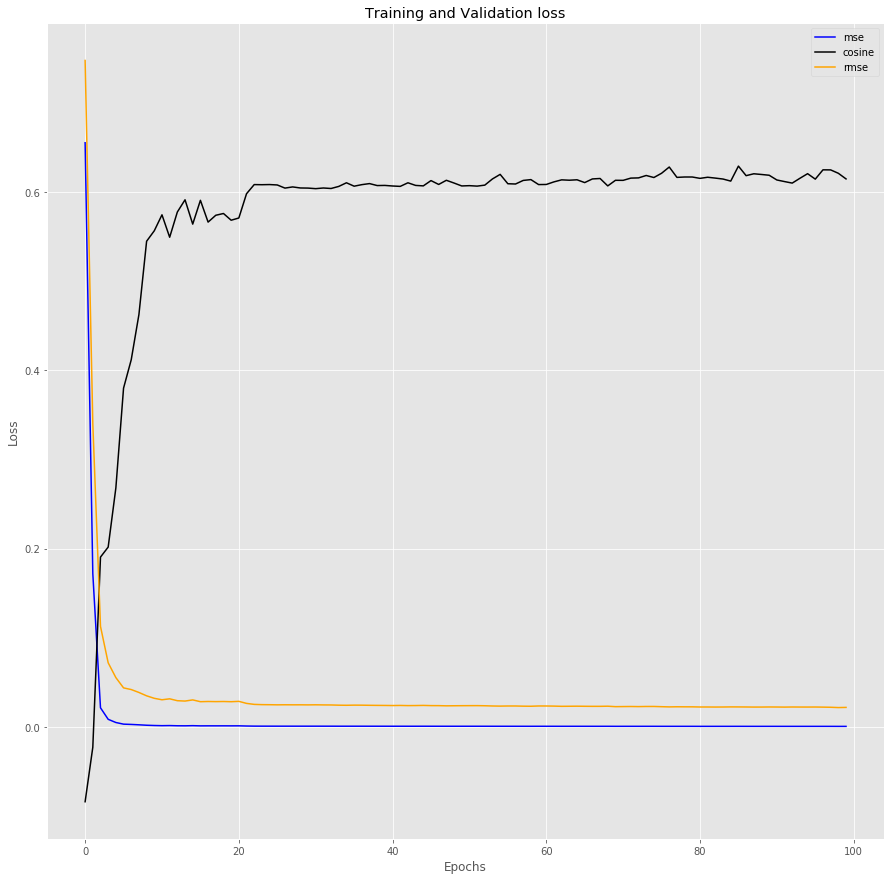

In [87]:
plt.figure(figsize=(15, 15))
loss_train = results.history['val_loss']
loss_val_mse = results.history['val_mse']
loss_val_mae = results.history['val_mae']
loss_val_mape = results.history['val_mape']
loss_val_cosine = results.history['val_cosine']
loss_val_rmse = results.history['val_rmse']
epochs = range(0,100)
#plt.plot(epochs, loss_train, 'green', label='Training loss')
plt.plot(epochs, loss_val_mse, 'blue', label='mse')
#plt.plot(epochs, loss_val_mape, 'red', label='mape')
plt.plot(epochs, loss_val_cosine, 'black', label='cosine')
plt.plot(epochs, loss_val_rmse, 'orange', label='rmse')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()

In [88]:
# Load best model
model.load_weights('model-tgs-salt_2.h5')

In [89]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, batch_size=1,verbose=1)

36/36 [==============================] - 7s 200ms/step


[0.000732027009588718,
 0.0007320269360207021,
 0.021833783015608788,
 818.4212036132812,
 0.6207819581031799,
 -0.0633755624294281,
 -0.06342444568872452,
 0.021833783015608788]

In [90]:

# Predict on train, val and test
preds_train = model.predict(X_train, batch_size=1,verbose=1)
preds_val = model.predict(X_valid, batch_size=1,verbose=1)


# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.float32)
#preds_val_t = (preds_val > 0.5).astype(np.float32)

36/36 [==============================] - 7s 194ms/step


In [91]:
print(preds_train.shape,type(preds_train) )
np.save('D:/aminur/data/result_train_120.npy',preds_train)

(84, 128, 128, 128, 1) <class 'numpy.ndarray'>


In [92]:
print(preds_val.shape,type(preds_val) )
np.save('D:/aminur/data/result_val_120.npy',preds_val)

(36, 128, 128, 128, 1) <class 'numpy.ndarray'>


In [93]:

max_value=17398.0390625
#preds_val=preds_val*max_value
preds_train1=preds_train.reshape(84,128,128,128)
preds_val1=preds_val.reshape(36,128,128,128)
np.save('D:/aminur/data/result_train_120_2.npy',preds_train1)
np.save('D:/aminur/data/result_val_120_2.npy',preds_val1)
#p=preds_val[1]
#print(p)
#print(preds_val[1])
#print(preds_val[1]*22479.19140625)
#preds_train2=preds_train1[0:300]*24022.943359375
#preds_val2=preds_val1*24022.943359375
preds_val2=preds_val1*max_value
preds_train2=preds_train1*max_value
np.save('D:/aminur/data/result_train_max_120_3.npy',preds_train2)
np.save('D:/aminur/data/result_val_max_120_3.npy',preds_val2)
#print(preds_val[1])




In [94]:
y=np.load('D:/aminur/data/test_120.npy')
print(y[14])
y14=y[108].reshape(128,128,128)
y14=y14*17398.0390625

[[[[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  ...

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]]


 [[[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.11771441]]

  [[-0.11771441]
   [-0.11771441]
   [-0.11771441]
   ...
   [-0.11771441]
   [-0.11771441]
   [-0.1177

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
#import sys
#!{sys.executable} -m pip install plotly
from plotly.tools import FigureFactory as FF
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Transposing surface
Calculating surface
Drawing


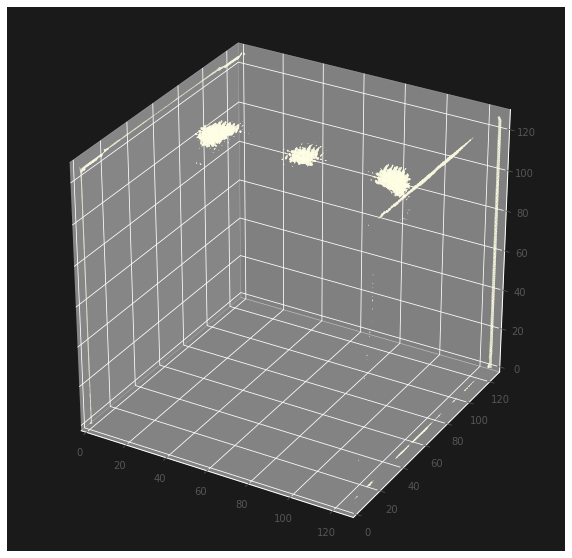

In [97]:
def make_mesh(image, threshold=-300, step_size=1):
    print("Transposing surface")
    p = image.transpose(2, 1, 0)
    #print(p.shape)

    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    #print ("v",verts.shape)
    #print("f",faces)
    #print("n",norm) 
    #print("v",val)
    return verts, faces


def plotly_3d(verts, faces):
    x, y, z = zip(*verts)

    print ("Drawing")

    # Make the colormap single color since the axes are positional not intensity.
    #colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap = ['rgb(236, 236, 212)', 'rgb(236, 236, 212)']
    

    fig = FF.create_trisurf(x=x,
                            y=y,
                            z=z,
                            plot_edges=False,
                            colormap=colormap,
                            simplices=faces,
                            backgroundcolor='rgb(64, 64, 64)',
                            title="Interactive Visualization")
    iplot(fig)


def plt_3d(verts, faces):
    print("Drawing")
    x, y, z = zip(*verts)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    #ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.patch.set_facecolor((0.10, 0.10, 0.10))
    #plt.savefig("./plot/3d_i2_106_2.png")
    #plt.show()

v, f = make_mesh(preds_train2[80], 350)
#v, f = make_mesh(y14, 350)
plt_3d(v, f)



In [99]:
print(preds_train2[14])
v, f = make_mesh(preds_val2[35], 350,3)
#v, f = make_mesh(y14, 350,3)
#print(preds_train1[6])
plotly_3d(v, f)

[[[-6.34811768e+02 -1.00210706e+03 -1.15252783e+03 ... -2.16158984e+03
   -3.28270898e+03 -2.45589551e+03]
  [-4.53801605e+02 -1.66836218e+03 -8.68601746e+02 ... -1.45198621e+03
   -2.18766553e+03 -1.22325439e+03]
  [-4.23122955e+02 -9.12073364e+02 -4.04187073e+02 ... -1.28393445e+03
   -1.78360315e+03 -6.35551819e+02]
  ...
  [ 3.98924683e+02 -1.16196826e+03 -2.70349182e+02 ... -1.34683826e+03
   -3.49560333e+02 -1.15440588e+03]
  [-1.36990341e+02 -1.15630322e+03 -1.66189240e+02 ...  2.60507385e+02
    1.01076514e+03  8.73892273e+02]
  [-1.28996240e+03 -1.87005054e+03 -1.33988635e+03 ... -1.30570349e+03
    6.89751648e+02  1.24874390e+03]]

 [[ 1.35425867e+03  1.07794373e+03 -3.06915771e+02 ... -6.92349670e+02
   -4.38472168e+03 -3.36460669e+03]
  [ 5.26208252e+02 -1.30766565e+03 -1.98139441e+03 ... -2.10398682e+03
   -4.24048584e+03 -3.55243433e+03]
  [ 8.29896118e+02  4.23796021e+02 -3.36918678e+01 ... -7.34217407e+02
   -2.14492261e+03 -1.95744031e+03]
  ...
  [-9.36454590e+02 -1.6

D:\Anaconda3\envs\deep\lib\site-packages\plotly\tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_trisurf is deprecated. Use plotly.figure_factory.create_trisurf



In [ ]:
x=preds_val1.min()
print(x)